# Hypersolvers for Optimal Control

### Basic usage of the `Hypersolver` API

We showcase the `torchdyn` API for [hypersolvers](https://arxiv.org/pdf/2007.09601.pdf). Hypersolvers, or hybrid ODE solvers equipped with a neural network to approximate residuals, are seamlessly integrated into the `odeint` API. A major design of the API is exactly preserving a persistent state for the solver, which in the case of standard ODE solvers contains the Tableau. For hypersolvers, the state also contains their hypernetwork parameters.

In [1]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

/home/botu/.local/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


## Optimal Control

We want to control an inverted pendulum and stabilize it in the upright position. The equations in Hamiltonian form describing an inverted pendulum with a torsional spring are as following:

\begin{equation}
    \begin{bmatrix} \dot{q}\\ \dot{p}\\ \end{bmatrix} = 
    \begin{bmatrix}
    0& 1/m \\
    -k& -\beta/m\\
    \end{bmatrix}
    \begin{bmatrix} q\\ p\\ \end{bmatrix} -
    \begin{bmatrix}
    0\\
    mgl \sin{q}\\
    \end{bmatrix}+
    \begin{bmatrix}
    0\\
    1\\
    \end{bmatrix} u
\end{equation}

In [2]:
class ControlledPendulum(nn.Module):
    """
    Inverted pendulum with torsional spring
    """
    def __init__(self, u, m=1., k=.5, l=1., qr=0., β=.01, g=9.81):
        super().__init__()
        self.u = u # controller (nn.Module)
        self.nfe = 0 # number of function evaluations
        self.cur_f = None # current function evaluation
        self.cur_u = None # current controller evaluation 
        self.m, self.k, self.l, self.qr, self.β, self.g = m, k, l, qr, β, g # physics
        
    def forward(self, t, x):
        self.nfe += 1
        q, p = x[..., :1], x[..., 1:]
        self.cur_u = self.u(t, x)
        dq = p/self.m
        dp = -self.k*(q - self.qr) - self.m*self.g*self.l*torch.sin(q) \
            -self.β*p/self.m + self.cur_u
        self.cur_f = torch.cat([dq, dp], -1)
        return self.cur_f

In order to control the pendulum, we have to define a proper _integral cost function_ which will be our loss to be minimized during training. In a general form, it can be defined as:

\begin{equation}
        J = x^\top(t_f)\mathbf{P} x(t_f) + \int_{t_0}^{t_f} \left[ x^\top(t) \mathbf{Q} x(t) + u^\top(t) \mathbf{R} u(t) \right] dt
\end{equation}

where $ x = \begin{bmatrix} q\\ p\\ \end{bmatrix}$ is the state and $\mathbf{u}$ is the controller and matrices $\mathbf{P},~\mathbf{Q}, ~ \mathbf{R}$ are weights for controlling the performance.

In [3]:
class IntegralCost(nn.Module):
    '''Integral cost function
    Args:
        x_star: torch.tensor, target position
        P: float, terminal cost weights
        Q: float, state weights
        R: float, controller regulator weights
    '''
    def __init__(self, x_star, P=0, Q=1, R=0):
        super().__init__()
        self.x_star = x_star
        self.P, self.Q, self.R, = P, Q, R
        
    def forward(self, x, u=torch.Tensor([0.])):
        """
        x: trajectory
        u: control input
        """
        cost = self.P*torch.norm(x[-1] - self.x_star, p=2, dim=-1).mean()
        cost += self.Q*torch.norm(x - self.x_star, p=2, dim=-1).mean()
        cost += self.R*torch.norm(u - 0, p=2).mean()
        return cost

In [4]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# The controller is a simple MLP with one hidden layer with bounded output
class NeuralController(nn.Module):
    def __init__(self, model, u_min=-20, u_max=20):
        super().__init__()
        self.model = model
        self.u_min, self.u_max = u_min, u_max
        
    def forward(self, t, x):
        x = self.model(x)
        return torch.clamp(x, self.u_min, self.u_max)

model = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 1)).to(device)
u = NeuralController(model) 
for p in u.model[-1].parameters(): torch.nn.init.zeros_(p)

# Controlled system
sys = ControlledPendulum(u).to(device)

In [6]:
from math import pi as π

# Loss function declaration
x_star = torch.Tensor([0., 0.]).to(device)
cost_func = IntegralCost(x_star)

# Time span
t0, tf = 0, 2 # initial and final time for controlling the system
steps = 20 + 1 # so we have a time step of 0.1s
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))

In [7]:
# Hyperparameters
lr = 3e-3
epochs = 500
bs = 1024
opt = torch.optim.Adam(u.parameters(), lr=lr)

# Training loop
t0 = time.time(); losses=[]
for e in range(epochs):
    x0 = init_dist.sample((bs,)).to(device)
    _, trajectory = odeint(sys, x0, t_span, solver='tsit5', atol=1e-7, rtol=1e-7)    
    loss = cost_func(trajectory); losses.append(loss.detach().cpu().item())
    loss.backward(); opt.step(); opt.zero_grad()
    print('Loss {:.4f} , epoch {}'.format(loss.item(), e), end='\r')
timing = time.time() - t0; print('\nTraining time: {:.4f} s'.format(timing))

Loss 0.9749 , epoch 499
Training time: 228.4546 s


Text(0.5, 0, '$t~[s]$')

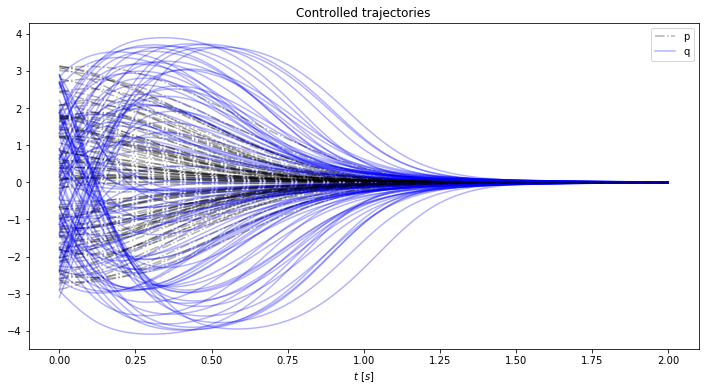

In [8]:
# Testing the controller on the real system
x0 = init_dist.sample((100,)).to(device)
t0, tf, steps = 0, 2, 20*10 + 1 
t_span_fine = torch.linspace(t0, tf, steps).to(device)
_, traj = odeint(sys, x0, t_span_fine, solver='tsit5', atol=1e-7, rtol=1e-7)
t_span_fine = t_span_fine.detach().cpu(); traj = traj.detach().cpu()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for i in range(len(x0)):
    ax.plot(t_span_fine, traj[:,i,0], 'k-.', alpha=.3, label='p' if i==0 else None)
    ax.plot(t_span_fine, traj[:,i,1], 'b', alpha=.3, label='q' if i==0 else None)
ax.legend()
ax.set_title('Controlled trajectories')
ax.set_xlabel(r"$t~[s]$")

Now we have to address one question: can we speed up the simulation?

## Hypersolvers for Controlled Systems

By training the hypersolver on residuals between the ground-truth solution and the base solver (we will use Euler in this case) we can render the training more efficient while retaining solution accuracy.

The residuals can be defined by:
\begin{equation}
\begin{aligned}
    R \left(t_k,  x(t_k), x(t_{k+1}) \right) = \Phi(x(t_k), t_k, t_{k+1}) - x(t_k) - \epsilon f(x_k, u_k)
    \label{eq:residual_hypereuler}
\end{aligned}
\end{equation}

where $\Phi$ is an accurate solver and $\epsilon$ is the time stepping.

The hypernet $g_w$ should have as input data important features for predicting future trajectories: we can use the current state $x$, its derivative $f$ and the control input $u$. The training will be carried out by minimizing a loss function like:

\begin{equation}
    \ell = \frac{1}{K} \sum_{k=0}^{K-1} \left|\left|{ R \left( t_k,  x(t_k), x(t_{k+1}) \right) - g_\omega\left(x(t_k), f(t_k), u(t_{k}) \right) }\right|\right|_2
    \label{eq:loss_hypersolver}
\end{equation}

In [9]:
# We consider the controller fixed during each solver step
class RandConstController(nn.Module):
    def __init__(self):
        super().__init__()
        self.u0 = torch.Tensor(1024, 1).uniform_(-10,10).to(device)
        
    def forward(self, t, x):
        return self.u0
    
# Save previously learned controller
u_no_hypersolver = sys.u
sys.u = RandConstController() # modify controller for training

In [10]:
class VanillaHyperNet(nn.Module):
    """Simple hypernetwork for controlled systems
    Input: current x, f and u from the controlled system
    Output: p-th order residuals"""
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def forward(self, t, x):
        xfu = torch.cat([x, sys.cur_f, sys.cur_u], -1)
        return self.net(xfu)
    
net = nn.Sequential(nn.Linear(5, 64), nn.Softplus(), nn.Linear(64, 64), nn.Softplus(), nn.Linear(64, 2))
hypersolver = HyperEuler(VanillaHyperNet(net))
model = nn.DataParallel(hypersolver, device_ids=[1]) # feel free to change here according to your setup and GPU available.
model = model.to(device)

## Training the Hypernetwork

Training the hypernetwork $g_w$ requires us to know which set its input values are contained in.
If we want the pendulum with initial states in $\pm \pi$, we can sample the input states for the hypernetwork from a distribution which includes possible states which the system can visit (i.e., the hypernetwork should be able to predict outside of the initial boundaries in a certain range). For example, we can draw the states $x$ from a Uniform distribution:
$$x = \begin{bmatrix} q\\ p\\ \end{bmatrix} \sim Uniform(-2\pi, 2\pi) \times Uniform(-2\pi, 2\pi)$$
Similarly, the controller values can be sampled from a distribution including all the possible controller values, such as
$$u \sim Uniform(-20, 20)$$

In [11]:
# Initial distribution
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))

base_solver = Euler()
# Time span
t0, tf = 0, 2 # initial and final time for controlling the system
steps = 20 + 1 # so we have a time step of 0.1s
t_span = torch.linspace(t0, tf, steps).to(device)
dt = (t_span[1] - t_span[0]).detach().cpu().item()

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
epochs = 10000
bs = 2048
hypernet = model.module.hypernet
span = torch.linspace(0, dt, 2)
losses = []

for i in range(epochs):
    # Sample random intial states and controllers
    x0 = init_dist.sample((bs,)).to(device)
    sys.u.u0 = torch.Tensor(bs, 1).uniform_(-20, 20).to(device)
    
     # Compute residuals
    _, sol_gt = odeint(sys, x0, span, solver='tsit5', atol=1e-8, rtol=1e-8)[-1]
    sol = x0 + sys(0., x0)*dt
    residuals = (sol_gt - sol) / dt**2
    residuals_hypersolver = hypernet(0., x0)
    loss = loss_func(residuals, residuals_hypersolver)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad()
    print(f'Step: {i}, Residual loss: {loss:.3f}', end='\r')
    losses.append(loss.detach().cpu().item())

Text(0.5, 0.98, 'Uncontrolled Trajectories')

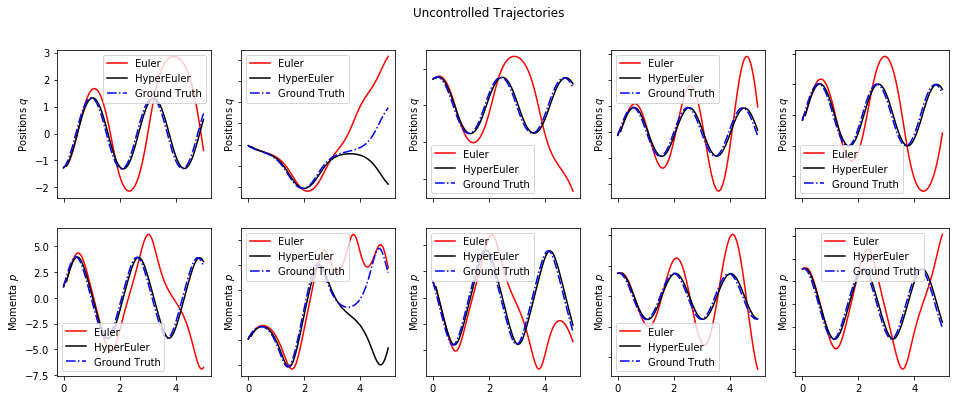

In [13]:
# Sample and plot some trajectories
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))
x0 = init_dist.sample((10000,)).to(device)
sys = ControlledPendulum(RandConstController()).to(device)
sys.u.u0 = torch.Tensor(10000, 1).uniform_(0,0).to(device)
t_span = torch.linspace(0, 5, 101).to(device)

_, traj_euler = odeint(sys, x0, t_span, solver='euler')
_, traj_hyper = odeint(sys, x0, t_span, solver=hypersolver)
_, traj_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-7, rtol=1e-7)
traj_euler = traj_euler.detach().cpu(); traj_hyper = traj_hyper.detach().cpu(); traj_gt = traj_gt.detach().cpu()
t_span = t_span.cpu()

fig, axs = plt.subplots(2, 5, figsize=(16,6))

for i in range(5):
    for j in range(2):
        axs[j, i].plot(t_span, traj_euler[:,i,j], 'r')
        axs[j, i].plot(t_span, traj_hyper[:,i,j], 'k')
        axs[j, i].plot(t_span, traj_gt[:,i,j], 'b-.')
        axs[j, i].legend(['Euler', 'HyperEuler', 'Ground Truth'])
        axs[j, i].label_outer()
    axs[0, i].set_ylabel(r'Positions $q$'); axs[1, i].set_ylabel(r'Momenta $p$')

fig.suptitle('Uncontrolled Trajectories')

Text(0.5, 0.98, 'SMAPE Propagation')

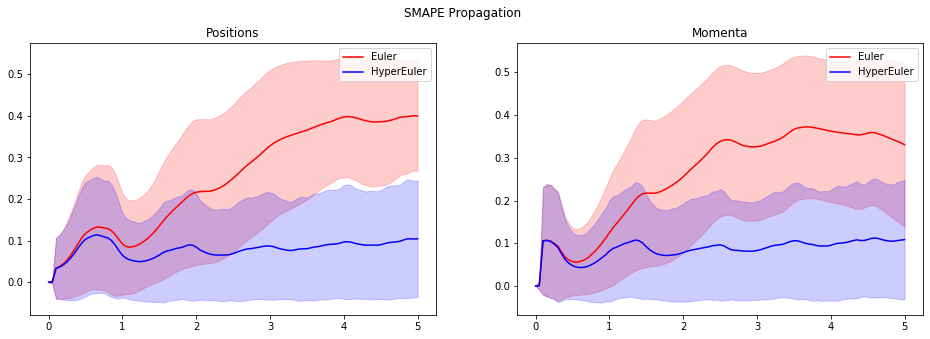

In [14]:
# Error analysis
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

err_euler, err_hyper = smape(traj_gt, traj_euler).detach().cpu(), smape(traj_gt, traj_hyper).detach().cpu()
mean_euler, std_euler = err_euler.mean(1), err_euler.std(1)
mean_hyper, std_hyper = err_hyper.mean(1), err_hyper.std(1)

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.plot(t_span, mean_euler[:,0], 'r', label='Euler')
ax.plot(t_span, mean_hyper[:,0], 'b', label='HyperEuler')
ax.fill_between(t_span, mean_euler[:,0]-std_euler[:,0], mean_euler[:,0]+std_euler[:,0], alpha=.2, color='r')
ax.fill_between(t_span, mean_hyper[:,0]-std_hyper[:,0], mean_hyper[:,0]+std_hyper[:,0], alpha=.2, color='b')
ax.legend()
ax.set_title('Positions')

ax = fig.add_subplot(1,2,2)
ax.plot(t_span, mean_euler[:,1], 'r', label='Euler')
ax.plot(t_span, mean_hyper[:,1], 'b', label='HyperEuler')
ax.fill_between(t_span, mean_euler[:,1]-std_euler[:,1], mean_euler[:,1]+std_euler[:,1], alpha=.2, color='r')
ax.fill_between(t_span, mean_hyper[:,1]-std_hyper[:,1], mean_hyper[:,1]+std_hyper[:,1], alpha=.2, color='b')
ax.legend()
ax.set_title('Momenta')
fig.suptitle('SMAPE Propagation')

Nice! We managed obtain a more accurate solver with respect to the Euler baseline. Now, let's see how this performs with optimal control.

## Optimal Control with Hypersolvers
We can use the trained hypernetwork to generate trajectories of the pendulum: then, we cast the same optimal control problem defined at the beginning of the notebook and train the neural controller.

In [15]:
# Reinstantiate controller
model = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 1)).to(device)
u = NeuralController(model) 
for p in u.model[-1].parameters(): torch.nn.init.zeros_(p)
sys.u = u

# Time span
t0, tf = 0, 2 # initial and final time for controlling the system
steps = 20 + 1 # so we have a time step of 0.1s
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))

In [16]:
# Hyperparameters
lr = 3e-3
epochs = 500
bs = 1024
opt = torch.optim.Adam(u.parameters(), lr=lr)

# Training loop
t0 = time.time(); losses=[]
for e in range(epochs):
    x0 = init_dist.sample((bs,)).to(device)
    _, trajectory = odeint(sys, x0, t_span, solver=hypersolver, atol=1e-7, rtol=1e-7)    
    loss = cost_func(trajectory); losses.append(loss.detach().cpu().item())
    loss.backward(); opt.step(); opt.zero_grad()
    print('Loss {:.4f} , epoch {}'.format(loss.item(), e), end='\r')
timing = time.time() - t0; print('\nTraining time: {:.4f} s'.format(timing))

Loss 1.1300 , epoch 499
Training time: 21.2143 s


In [17]:
# Comparing inference times between Euler, HyperEuler, RK4 (fixed-step, 4th order solver) and the base solver
t_span_test = torch.linspace(0, 100, 1001)
x0 = init_dist.sample((bs,)).to(device)
t0 = time.time(); odeint(sys, x0, t_span_test, solver='euler'); timing_euler = time.time() - t0
t0 = time.time(); odeint(sys, x0, t_span_test, solver=hypersolver); timing_hyper = time.time() - t0
t0 = time.time(); odeint(sys, x0, t_span_test, solver='rk4'); timing_rk4 = time.time() - t0
t0 = time.time(); odeint(sys, x0, t_span_test, solver='tsit5', atol=1e-7, rtol=1e-7); timing_tsit5 = time.time() - t0
print('Inference times\nEuler: {:.4f} s\nHyperEuler: {:.4f} s\nRunge-Kutta-4: {:.4f} s\nTsitouras: {:.4f} s'.format(timing_euler, timing_hyper, timing_rk4, timing_tsit5))

Inference times
Euler: 0.2584 s
HyperEuler: 0.4956 s
Runge-Kutta-4: 1.0962 s
Tsitouras: 2.6975 s


Text(0.5, 0, '$t~[s]$')

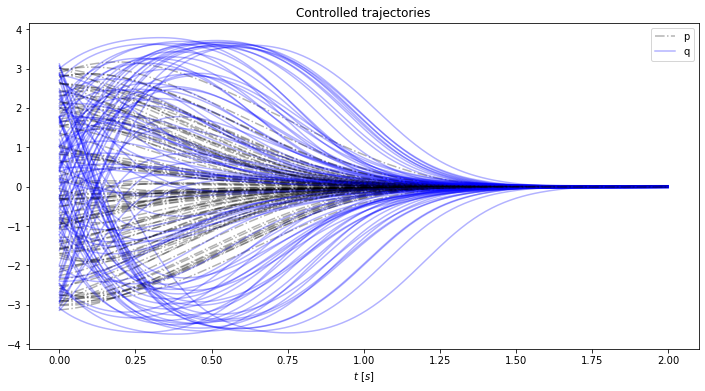

In [19]:
# Testing the controller on the real system
x0 = init_dist.sample((100,)).to(device)
t0, tf, steps = 0, 2, 20*10 + 1 # nominal trajectory
t_span_fine = torch.linspace(t0, tf, steps).to(device)
_, traj = odeint(sys, x0, t_span_fine, solver='tsit5', atol=1e-7, rtol=1e-7)
t_span_fine = t_span_fine.detach().cpu(); traj = traj.detach().cpu()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for i in range(len(x0)):
    ax.plot(t_span_fine, traj[:,i,0], 'k-.', alpha=.3, label='p' if i==0 else None)
    ax.plot(t_span_fine, traj[:,i,1], 'b', alpha=.3, label='q' if i==0 else None)
ax.legend()
ax.set_title('Controlled trajectories')
ax.set_xlabel(r"$t~[s]$")

Great 🎉

Training the controller with `HyperEuler` resulted in a working controller stabilizing the system in the given time; more importantly, while in the first part we used a high accuracy solver to obtain similar results, which took us 220 seconds, training with the same number of epochs and all the same hyperparameters but using the hypersolver took less than 20 seconds : more than $10\times$ faster!